## ECL 연구프로젝트 스터디 2차
### PyTorch Tutorial
kaggle Playground Competition - [Aerial Cactus Identification](https://https://www.kaggle.com/c/aerial-cactus-identification)</br>
PyTorch를 이용해 간단한 Image Classification 문제를 해결해봅시다~!

In [10]:
import numpy as np
import pandas as pd
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms

from sklearn.model_selection import train_test_split
from typing import Type, Any, Callable, Union, List, Optional
from tqdm.auto import tqdm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

# 데이터 Setup

In [11]:
!unzip /content/aerial-cactus-identification.zip

Archive:  /content/aerial-cactus-identification.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
!unzip /content/train.zip
!unzip /content/test.zip

Archive:  /content/train.zip
replace train/008bd3d84a1145e154409c124de7cee9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/test.zip
replace test/000940378805c44108d287872b2f04ce.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
# train.csv 열기
labels = pd.read_csv("/content/train.csv")
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


## Sample Image 출력

In [14]:
# image 디렉토리 경로 지정
train_dir = '/content/train'
test_dir = '/content/test'

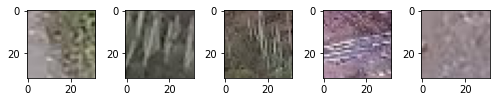

In [15]:
# sample image 5개 출력
sample_path = random.sample(os.listdir(train_dir), 5)

fig, axs = plt.subplots(1, 5)
fig.set_size_inches(7, 15)
for i, path in enumerate(sample_path):
    sample = mpimg.imread(os.path.join(train_dir, path))
    axs[i].imshow(sample)
fig.tight_layout()
plt.show()

## Custom Dataset를 생성하고, DataLoader로 데이터 불러오기
![](https://blog.kakaocdn.net/dn/b0SVvH/btqLq2FmuEs/1hnCz8VL9wvXPKTOTXzvOk/img.jpg)</br></br>
PyTorch로 데이터를 불러오기 위해서는 custom Dataset class를 생성하고, DataLoader로 dataset class를 불러와야한다.

<dl class="class">
<dt id="torch.utils.data.Dataset">
<em class="property">class </em><code class="sig-prename descclassname">torch.utils.data.</code><code class="sig-name descname">Dataset</code></dt>
<dd><p>An abstract class representing a <a class="reference internal" href="#torch.utils.data.Dataset" title="torch.utils.data.Dataset"><code class="xref py py-class docutils literal notranslate"><span class="pre">Dataset</span></code></a>.</p>
<p>All datasets that represent a map from keys to data samples should subclass
it. All subclasses should overwrite <code class="xref py py-meth docutils literal notranslate"><span class="pre">__getitem__()</span></code>, supporting fetching a
data sample for a given key. Subclasses could also optionally overwrite
<code class="xref py py-meth docutils literal notranslate"><span class="pre">__len__()</span></code>, which is expected to return the size of the dataset by many
<a class="reference internal" href="#torch.utils.data.Sampler" title="torch.utils.data.Sampler"><code class="xref py py-class docutils literal notranslate"><span class="pre">Sampler</span></code></a> implementations and the default options
of <a class="reference internal" href="#torch.utils.data.DataLoader" title="torch.utils.data.DataLoader"><code class="xref py py-class docutils literal notranslate"><span class="pre"><span class="highlighted">DataLoader</span></span></code></a>.</p>
<div class="admonition note">
<p class="admonition-title">Note</p>
<p><a class="reference internal" href="#torch.utils.data.DataLoader" title="torch.utils.data.DataLoader"><code class="xref py py-class docutils literal notranslate"><span class="pre"><span class="highlighted">DataLoader</span></span></code></a> by default constructs a index
sampler that yields integral indices.  To make it work with a map-style
dataset with non-integral indices/keys, a custom sampler must be provided.</p>
</div>
</dd></dl>

<pre><span></span><span class="n"><span class="highlighted">DataLoader</span></span><span class="p">(</span><span class="n">dataset</span><span class="p">,</span> <span class="n">batch_size</span><span class="o">=</span><span class="mi">1</span><span class="p">,</span> <span class="n">shuffle</span><span class="o">=</span><span class="kc">False</span><span class="p">,</span> <span class="n">sampler</span><span class="o">=</span><span class="kc">None</span><span class="p">,</span>
           <span class="n">batch_sampler</span><span class="o">=</span><span class="kc">None</span><span class="p">,</span> <span class="n">num_workers</span><span class="o">=</span><span class="mi">0</span><span class="p">,</span> <span class="n">collate_fn</span><span class="o">=</span><span class="kc">None</span><span class="p">,</span>
           <span class="n">pin_memory</span><span class="o">=</span><span class="kc">False</span><span class="p">,</span> <span class="n">drop_last</span><span class="o">=</span><span class="kc">False</span><span class="p">,</span> <span class="n">timeout</span><span class="o">=</span><span class="mi">0</span><span class="p">,</span>
           <span class="n">worker_init_fn</span><span class="o">=</span><span class="kc">None</span><span class="p">,</span> <span class="o">*</span><span class="p">,</span> <span class="n">prefetch_factor</span><span class="o">=</span><span class="mi">2</span><span class="p">,</span>
           <span class="n">persistent_workers</span><span class="o">=</span><span class="kc">False</span><span class="p">)</span>
</pre>

In [16]:
# custom Dataset 만들기
class CactusData(Dataset):
    def __init__(self, df, data_dir, transform):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    # 데이터셋 크기 return
    def __len__(self):
        return len(self.df)

    # 주어진 index에 해당하는 데이터 return
    def __getitem__(self, index):
        img_name = self.df.id[index]
        label = self.df.has_cactus[index]

        img_path = os.path.join(self.data_dir, img_name)
        image = mpimg.imread(img_path)
        image = self.transform(image)
        return image, label

In [17]:
# train, validation 데이터 split
t, v = train_test_split(labels, test_size=0.2, shuffle=True, random_state=77)
t = t.reset_index(drop=True)
v = v.reset_index(drop=True)

In [18]:
# data transform 정의
data_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])


# Dataset 객체 생성 후, DataLoader로 tensor형식 데이터 iterator 불러오기
train_data = CactusData(df=t, data_dir =train_dir, transform=data_transform)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

val_data = CactusData(df=v, data_dir =train_dir, transform=data_transform)
val_loader = DataLoader(dataset=val_data, batch_size=64, shuffle=True)

# Model 만들기

<dt id="torch.nn.Conv2d">
<em class="property">class </em><code class="sig-prename descclassname">torch.nn.</code><code class="sig-name descname">Conv2d</code><span class="sig-paren">(</span><em class="sig-param">in_channels</em>, <em class="sig-param">out_channels</em>, <em class="sig-param">kernel_size</em>, <em class="sig-param">stride=1</em>, <em class="sig-param">padding=0</em>, <em class="sig-param">dilation=1</em>, <em class="sig-param">groups=1</em>, <em class="sig-param">bias=True</em>, <em class="sig-param">padding_mode='zeros'</em><span class="sig-paren">)</span></a></dt>

<ul>
<li><p><code class="xref py py-attr docutils literal notranslate"><span class="pre">stride</span></code> controls the stride for the cross-correlation, a single
number or a tuple.</p></li>
<li><p><code class="xref py py-attr docutils literal notranslate"><span class="pre">padding</span></code> controls the amount of implicit padding on both
sides for <code class="xref py py-attr docutils literal notranslate"><span class="pre">padding</span></code> number of points for each dimension.</p></li>
<li><p><code class="xref py py-attr docutils literal notranslate"><span class="pre">dilation</span></code> controls the spacing between the kernel points; also
known as the à trous algorithm. It is harder to describe, but this <a class="reference external" href="https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md">link</a>
has a nice visualization of what <code class="xref py py-attr docutils literal notranslate"><span class="pre">dilation</span></code> does.</p></li>
<li><p><code class="xref py py-attr docutils literal notranslate"><span class="pre">groups</span></code> controls the connections between inputs and outputs.
<code class="xref py py-attr docutils literal notranslate"><span class="pre">in_channels</span></code> and <code class="xref py py-attr docutils literal notranslate"><span class="pre">out_channels</span></code> must both be divisible by
<code class="xref py py-attr docutils literal notranslate"><span class="pre">groups</span></code>. For example,</p>
<blockquote>
<div><ul class="simple">
<li><p>At groups=1, all inputs are convolved to all outputs.</p></li>
<li><p>At groups=2, the operation becomes equivalent to having two conv
layers side by side, each seeing half the input channels
and producing half the output channels, and both subsequently
concatenated.</p></li>
<li><p>At groups= <code class="xref py py-attr docutils literal notranslate"><span class="pre">in_channels</span></code>, each input channel is convolved with
its own set of filters (of size
<span class="math"><span class="katex"><span class="katex-mathml"><math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mfrac><mtext>out_channels</mtext><mtext>in_channels</mtext></mfrac></mrow><annotation encoding="application/x-tex">\frac{\text{out\_channels}}{\text{in\_channels}}</annotation></semantics></math></span><span class="katex-html" aria-hidden="true"><span class="base"><span class="strut" style="height:1.5751079999999997em;vertical-align:-0.5619999999999999em;"></span><span class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist" style="height:1.013108em;"><span style="top:-2.6550000000000002em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">in_channels</span></span></span></span></span><span style="top:-3.23em;"><span class="pstrut" style="height:3em;"></span><span class="frac-line" style="border-bottom-width:0.04em;"></span></span><span style="top:-3.527em;"><span class="pstrut" style="height:3em;"></span><span class="sizing reset-size6 size3 mtight"><span class="mord mtight"><span class="mord text mtight"><span class="mord mtight">out_channels</span></span></span></span></span></span><span class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist" style="height:0.5619999999999999em;"><span></span></span></span></span></span><span class="mclose nulldelimiter"></span></span></span></span></span>

</span>).</p></li>
</ul>
</div></blockquote>
</li>
</ul>

## 간단한 모델구조 생성

In [19]:
class SimpleModel(nn.Module):
    def __init__(self, in_channels, hid_channels, out_num):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hid_channels, kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(hid_channels)

        self.conv2 = nn.Conv2d(hid_channels, hid_channels, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(hid_channels)

        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(hid_channels, out_num)

    def forward(self, x):

        print("before convolution 1: ", x.size())
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        print("after convolution 1: ", x.size())

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        print("after convolution 2: ", x.size())

        x = self.gap(x)

        print("after average pooling: ", x.size())

        x = torch.flatten(x, 1)

        print("after flatten: ", x.size())

        x = self.fc1(x)

        print("after fully connected: ", x.size())

        return x

In [20]:
# 모델 생성 후 모델정보 출력
simple_model = SimpleModel(3, 32, 1)
print(simple_model)

SimpleModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


## Conv2d Shape</br>
$$ Input: (N, C_{in}, H_{in}, W_{in}) $$
$$ Output: (N, C_{out}, H_{out}, W_{out}) $$

$${H_{out}}=⌊\frac{H_{in}+2×padding[0]−dilation[0]×(kernelsize[0]−1)−1}{stride[0]}+1⌋$$

$$W_{out}=⌊\frac{{W_{in}}+2×padding[1]−dilation[1]×(kernelsize[1]−1)−1}{stride[1]}+1⌋ $$

In [21]:
# 데이터를 모델에 넣으면 결과가 어떻게 나오는지 한번 봅시다!

sample = next(iter(train_loader))
output = simple_model(sample[0]).detach().numpy()
print(output.shape)
# print(output)

before convolution 1:  torch.Size([64, 3, 32, 32])
after convolution 1:  torch.Size([64, 32, 15, 15])
after convolution 2:  torch.Size([64, 32, 7, 7])
after average pooling:  torch.Size([64, 32, 1, 1])
after flatten:  torch.Size([64, 32])
after fully connected:  torch.Size([64, 1])
(64, 1)


## 복잡한 모델 만들기
![](https://krshrimali.github.io/assets/ResNet18-Architecture.png)

## BasicBlock

![](https://i.imgur.com/Aj8dDLj.png)

In [22]:
def conv3x3(in_channels, out_channels, stride=1, dilation=1) -> nn.Conv2d:
  return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                   padding=dilation, bias=False, dilation=dilation)
  
def conv1x1(in_channels, out_channels, stride=1) -> nn.Conv2d:
  return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
  

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self, in_channels: int, channels: int, stride: int = 1):
        super(BasicBlock, self).__init__()
                
        # actual layers
        self.conv1 = conv3x3(in_channels, channels, stride)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(channels, channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.stride = stride
        self.downsample = nn.Sequential(
                conv1x1(in_channels, channels, stride),
                nn.BatchNorm2d(channels),
            )
    
    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.downsample(identity)
        out = self.relu(out)

        return out

## Bottleneck

In [23]:
class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
        self,
        in_channels,
        channels,
        stride,
        downsample: Optional[nn.Module] = None,
        groups: int=1,
        base_width:int = 64,
        dilation: int=1,
        norm_layer:Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(channels * (base_width / 64.)) * groups
        
        # actual layer
        self.conv1 = conv1x1(in_channels, width)
        self.bn1 = norm_layer(width)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, channels*self.expansion)
        self.bn3 = norm_layer(channels*self.expansion)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)

        return out

## Resnet

In [28]:
class ResNet(nn.Module):

    def __init__(self, block, layers: List[int],):
        super(ResNet, self).__init__()
        self.norm_layer = nn.BatchNorm2d

        self.in_channels = 64
        self.dilation = 1

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = self.norm_layer(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(256, 1)

        # weight/bias initialize
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    # 블록을 쌓아주는 함수
    def _make_layer(self, block, channels, block_num, stride: int=1) -> nn.Sequential:
        
        layers = []
        layers.append(block(self.in_channels, channels, stride))
        self.in_channels = channels * block.expansion
        for _ in range(1, block_num):
            layers.append(block(self.in_channels, channels, stride))
            
        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.sigmoid(x)

        return x

In [27]:
resnet = ResNet(BasicBlock, [2, 2, 2, 2])
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1)

# Training

In [30]:
# optimizer, loss function 정의
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4)
loss_function = nn.BCELoss()

In [31]:
def accuracy(pred, target):
    y_pred_tag = torch.round(pred)
    correct_sum = (y_pred_tag == target).sum().item()
    acc = correct_sum / target.shape[0]

    return acc

![](https://pytorch.org/tutorials/_images/comp-graph.png)

파이토치의 gradient는 x가 network를 통과하면서 자동으로 계산된다(autograd)</br>
graident의 미분값은 **loss.backward()**를 호출해 계산하고,</br>
**optimizer.step()**을 호출해 parameter(weight, bias)들을 update한다.</br>
따라서 training 동안은 위 함수들을 호출하지만, evaluation 동안은 gradient가 적용되지 않아야 하므로,</br> **torch.no_grad()**로 network 진행동안 graident가 기록되지 않도록 한다.



In [34]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

def train(model, epoch, dataloader, optimizer, loss_function):
    model.train()
    loss_log = []
    acc_log = []
    with tqdm(dataloader, unit="batch") as tepoch:
        for data, target in tepoch:
            data, target = data.cuda(), target.cuda()
            target = target.float()

            # optimizer gradient 초기화
            optimizer.zero_grad()

            output = model(data)
            # unsqueeze : [64] -> [64,1]
            loss = loss_function(output, target.unsqueeze(1))

            # grad 미분값 계산 후 모델 update
            loss.backward()
            optimizer.step()
            
            # accuracy & loss 저장 후 출력
            acc = accuracy(output, target.unsqueeze(1))
            loss_log.append(loss.item())
            acc_log.append(acc)
            tepoch.set_postfix(epoch=epoch, step="train", loss=np.mean(loss_log), accuracy=np.mean(acc_log))

def eval(model, epoch, dataloader, loss_function):
    model.eval()
    loss_log = []
    acc_log = []
    with tqdm(dataloader, unit="batch") as tepoch:
        # no_grad를 호출해 evaluation동안 gradient 계산 X
        with torch.no_grad():
            for data, target in tepoch:
                data, target = data.cuda(), target.cuda()
                target = target.float()

                output = model(data)
                loss = loss_function(output, target.unsqueeze(1))

                loss_log.append(loss.item())
                acc = accuracy(output, target.unsqueeze(1))
                acc_log.append(acc)
                tepoch.set_postfix(epoch=epoch, step="eval", loss=np.mean(loss_log), accuracy=np.mean(acc_log))


In [35]:
# Train Model
%%time
resnet.to('cuda')

for epoch in range(10):
    train(resnet, epoch, train_loader, optimizer, loss_function)
    eval(resnet, epoch, val_loader, loss_function)



CPU times: user 1min 55s, sys: 16.5 s, total: 2min 12s
Wall time: 2min 20s


# Evaluation

In [36]:
submit = pd.read_csv('/content/sample_submission.csv')
test_data = CactusData(df = submit, data_dir = test_dir, transform = data_transform)
test_loader = DataLoader(dataset = test_data, shuffle=False)

In [37]:
%%time
predict = []
resnet.eval()
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.cuda()
        output = resnet(data)    

        predict.append(int(output.item() > 0.5))
    
submit['has_cactus'] = predict
submit.to_csv('/content/submission.csv', index=False)

CPU times: user 9.88 s, sys: 187 ms, total: 10.1 s
Wall time: 10.1 s


In [38]:
submit.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1
